In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from glob import glob
from os import path
from scipy import stats
import pingouin as pg


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from dual_data_utils import make_clean_concat_data
from stopsignalmetrics import StopData, SSRTmodel, Violations, PostStopSlow
%matplotlib inline

/Users/henrymj/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
dataset= 'discovery'

In [3]:
OUTLIER_THRESH  = 3
SSD_THRESH = 200

dual_dict = {
    'stop_signal_with_cued_task_switching': {
        'dual_col': 'cue_task_switch',
        'DC': 'cue_stay_task_stay',
        'DE': 'cue_switch_task_switch',
        'OTHER': ['cue_switch_task_stay']
    },
    'stop_signal_with_directed_forgetting': {
        'dual_col': 'directed_forgetting_condition',
        'DC': 'con',
        'DE': 'neg',
        'OTHER': ['pos']
    },
    'stop_signal_with_flanker': {
        'dual_col': 'flanker_condition',
        'DC': 'congruent',
        'DE': 'incongruent'
    },
    'stop_signal_with_go_no_go': {
        'dual_col': 'go_nogo_condition',
        'DC': 'go',
        'DE': 'nogo'
    },
    'stop_signal_with_n_back': {
        'dual_col': 'delay_condition',
        'DC': 1.,
        'DE': 2.,
        'OTHER': [3.]
    },
    'stop_signal_with_predictable_task_switching': {
        'dual_col': 'predictable_condition',
        'DC': 'stay',
        'DE': 'switch'
    },
    'stop_signal_with_shape_matching': {
        'dual_col': 'shape_matching_condition',
        'DC': 'CONTROL',
        'DE': 'DISTRACTOR',
        'OTHER': ['DSD', 'SSS']
    },
}

stopmetrics_var_dict = {
    'columns': {
        'ID': 'worker_id',
        'block': 'current_block',
        'condition': 'SS_trial_type',
        'SSD': 'SS_delay',
        'goRT': 'rt',
        'stopRT': 'rt',
        'response': 'key_press',
        'correct_response': 'choice_correct_response',
        'choice_accuracy': 'choice_accuracy'},
    'key_codes': {
        'go': 'go',
        'stop': 'stop',
        'correct': 1,
        'incorrect': 0,
        'noResponse': -1}}

In [4]:
def get_query_str(col, condition):
    if type(condition)==str:
        return "%s=='%s'" % (col, condition)
    elif type(condition) in [float, int]:
        return "%s==%s" % (col, condition)
    elif type(condition)==list:
        return "%s in %s" % (col, condition)

def mean_pss(data_df, stop_type='all', query_suffix=None):
    return PostStopSlow().fit_transform(
        data_df, stop_type=stop_type, level='group', query_suffix=query_suffix,
    ).reset_index().groupby('ID').apply(
        lambda x: (x[f'post_goRT'] - x[f'pre_goRT']
                  ).mean()
    )

def stop_summarize(curr_data, thresh=SSD_THRESH, query_str=None):
    data_df = curr_data.query(query_str) if query_str is not None else curr_data
    
    sum_df = SSRTmodel().fit_transform(data_df, level='group')
    sum_df_threshSSDs = SSRTmodel().fit_transform(data_df.query(f'SSD>={thresh} or condition=="go"'), level='group').add_suffix('_wThresh_SSDs')
    sum_df_threshSubs = sum_df.query(f"mean_SSD >= {thresh}").add_suffix('_wThresh_subs')
    sum_df = pd.concat([sum_df, sum_df_threshSSDs, sum_df_threshSubs],
                       1,
                       sort=True
                      )
    query_suffix = "& "+query_str if query_str is not None else None
    for stop_type in ['all', 'fail', 'success']:
        full_pss = mean_pss(curr_data, stop_type=stop_type, query_suffix=query_suffix).rename('PSS_%s' % stop_type)
        sum_df = pd.concat(
            [sum_df, full_pss,
            mean_pss(data_df.query(f'SSD>={thresh} or condition=="go"'), stop_type=stop_type, query_suffix=query_suffix).rename('PSS_%s_wThresh_SSDs' % stop_type),
            full_pss[sum_df_threshSubs.index].copy().rename('PSS_%s_wThresh_subs' % stop_type)],
            1,
            sort=True
        )
    return sum_df

def get_inhib_func(curr_data, cond):
    inhib_df = pd.DataFrame(curr_data.groupby(['ID', 'SSD']).apply(lambda x: x.stopRT.notnull().sum()/len(x))).reset_index()
    inhib_df['condition'] = cond
    return inhib_df

def get_gng_presp(curr_data):
    curr_data = curr_data.copy()
    stop_trials = curr_data.query("stop_signal_condition=='stop'")
    out={}
    out['p_resp'] = (stop_trials.rt != -1).sum()/len(stop_trials)
    out['p_resp_go'] = (stop_trials.query("go_nogo_condition=='go'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='go'"))
    out['p_resp_nogo'] = (stop_trials.query("go_nogo_condition=='nogo'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='nogo'"))
    return out

In [5]:
stop_data_dict = make_clean_concat_data(stop_subset=True, dataset=dataset)

del stop_data_dict['stop_signal_with_go_no_go'] # remove GNG before subsetting based on performance

In [6]:
# build dict
ssrtc_out = {}
violation_out = {}
viols_noThresh_out = {}
all_ssd_out = {}
inhib_func = {}
for task_name in stop_data_dict.keys():  # [k for k in stop_data_dict.keys()][:1]:  # development loop using just 1st task
    curr_data = StopData(stopmetrics_var_dict).fit_transform(stop_data_dict[task_name].drop(columns=['correct_response']))
    short_name = task_name.split('_with_')[-1]
    all_ssd_out[short_name] = curr_data[['SSD', 'ID']].dropna()
    inhib_df = get_inhib_func(curr_data, 'full_task')
    ssrtc_out[short_name] = stop_summarize(curr_data)
    violation_df = Violations().fit_transform(curr_data, level='group')
    violation_df['condition'] = 'full_task'
    viols_noThresh_df = Violations(n_pair_thresh=1, ssd_quantity_thresh=1).fit_transform(curr_data, level='group')  # instead of 2,5 respectively
    viols_noThresh_df['condition'] = 'full_task'
    
    if 'with' in task_name:
        dual_col = dual_dict[task_name]['dual_col']
        for key in [k for k in dual_dict[task_name] if k!='dual_col']:
            query_str = get_query_str(dual_col, dual_dict[task_name][key])
            ssrtc_out['%s_%s' % (short_name,key)] = stop_summarize(
                curr_data,
                query_str=query_str
            )
            curr_va_df = Violations().fit_transform(curr_data, level='group', query_suffix="& "+query_str)
            curr_va_df['condition'] = key
            violation_df = pd.concat([violation_df, curr_va_df])
            
            curr_va_noThresh_df = Violations(n_pair_thresh=1, ssd_quantity_thresh=1).fit_transform(curr_data, level='group', query_suffix="& "+query_str)  # instead of 2,5 respectively
            curr_va_noThresh_df['condition'] = key
            viols_noThresh_df = pd.concat([viols_noThresh_df, curr_va_noThresh_df])
            inhib_df = pd.concat([inhib_df, get_inhib_func(curr_data.query(get_query_str(dual_col, dual_dict[task_name][key])), key)])
            
    inhib_func[short_name] = inhib_df
    violation_out[short_name] = violation_df
    viols_noThresh_out[short_name] = viols_noThresh_df
ssrtc_out['SE'] = ssrtc_out.pop('stop_signal_single_task_network')
metrics = [c for c in ssrtc_out['SE'].columns if 'max_RT' not in c]

#flatten data, remove outliers
flattened_data = pd.concat([ssrtc_out[k].add_prefix(k+'_') for k in ssrtc_out], axis=1, sort=True)
flattened_data = flattened_data.filter(regex='SE|DC|DE|OTHER|PSS_all|PSS_fail|PSS_success', axis=1)
z_df = flattened_data.apply(stats.zscore).apply(np.abs)
flattened_data[z_df>OUTLIER_THRESH] = None
flattened_data.index.name='ID'

# group by metric across tasks
metric_dict = {met: flattened_data.loc[:, ~flattened_data.columns.str.contains("wThresh")].filter(regex=met).copy() for met in metrics if 'wThresh' not in met}
metric_dict.update({
    met: flattened_data.loc[:,flattened_data.columns.str.contains("wThresh_SSDs")].filter(regex=met).copy() for met in metrics if 'wThresh_SSDs' in met
})
metric_dict.update({
    met: flattened_data.loc[:,flattened_data.columns.str.contains("wThresh_subs")].filter(regex=met).copy() for met in metrics if 'wThresh_subs' in met
})

In [7]:
# re checking individual task effects to make sure they match with the original notebooks

In [8]:
effect_map = {
    'flanker': {
        'col': 'flanker_condition',
        'base': 'congruent',
        'hard': ['incongruent']
    },
    'cued_task_switching': {
        'col': 'cue_task_switch',
        'base': 'cue_stay_task_stay',
        'hard': ['cue_switch_task_stay', 'cue_switch_task_switch']
    },
    'predictable_task_switching': {
        'col': 'predictable_condition',
        'base': 'stay',
        'hard': ['switch']
    },
    'directed_forgetting': {
        'col': 'directed_forgetting_condition',
        'base': 'con',
        'hard': ['neg', 'pos']
    },
    'shape_matching': {
        'col': 'shape_matching_condition',
        'base': 'CONTROL',
        'hard': ['DISTRACTOR']
    },
    'n_back': {
        'col': 'delay_condition',
        'base': 1,
        'hard': [2, 3]
    },
}

cost_map = {
    'cued_task_switching': ['cue_switch_task_stay-cue_stay_task_stay_', 'cue_switch_task_switch-cue_stay_task_stay_', 'task_switch-cue_switch_'],
    'directed_forgetting': ['neg-con_', 'pos-con_'],
    'n_back': ['2-1_', '3-1_']
}

def get_task_effects(subj_df, task):
    task_map = effect_map[task]
    subj_df = subj_df.copy().reset_index()
    #subset to go response trials
    go_resp_idx = (subj_df['stop_signal_condition']=='go') &(subj_df['rt'] > 0)
    subj_df = subj_df[go_resp_idx].copy()
    result_dict = {}
    for metric in ['rt', 'choice_accuracy']:
        if metric=='rt': #if RT, subset to correct trials
            curr_df = subj_df[subj_df['choice_accuracy']==1] 
        else:
            curr_df = subj_df
        base_val = curr_df.loc[curr_df[task_map['col']]==task_map['base'], metric].mean()
        for hard_col in task_map['hard']:
            hard_val = curr_df.loc[curr_df[task_map['col']]==hard_col, metric].mean()
            result_dict['%s-%s_%s' % (hard_col, task_map['base'], metric)] = hard_val - base_val
        if task=='cued_task_switching': # get residual switch cost
            result_dict['task_switch-cue_switch_%s' % metric] = curr_df.loc[curr_df[task_map['col']]=='cue_switch_task_switch', metric].mean() -\
                                                                curr_df.loc[curr_df[task_map['col']]=='cue_switch_task_stay', metric].mean()
    return result_dict

# 1. Replicate task effects as sanity check

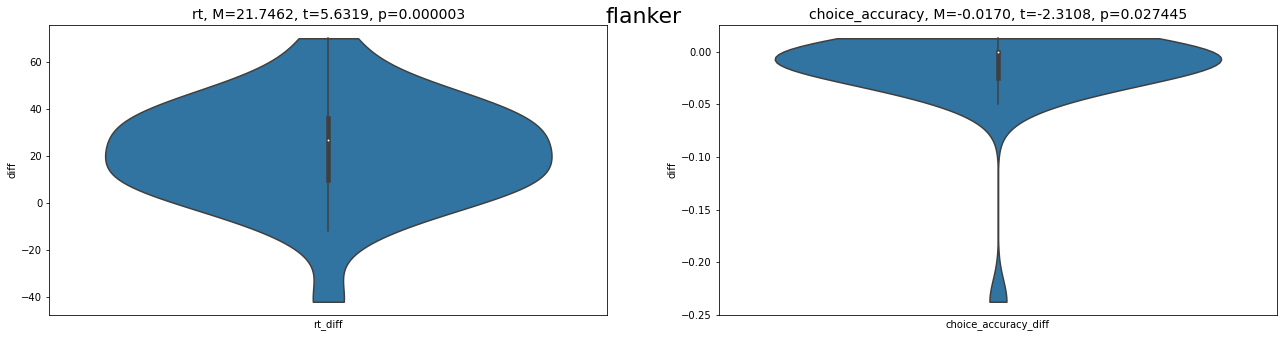

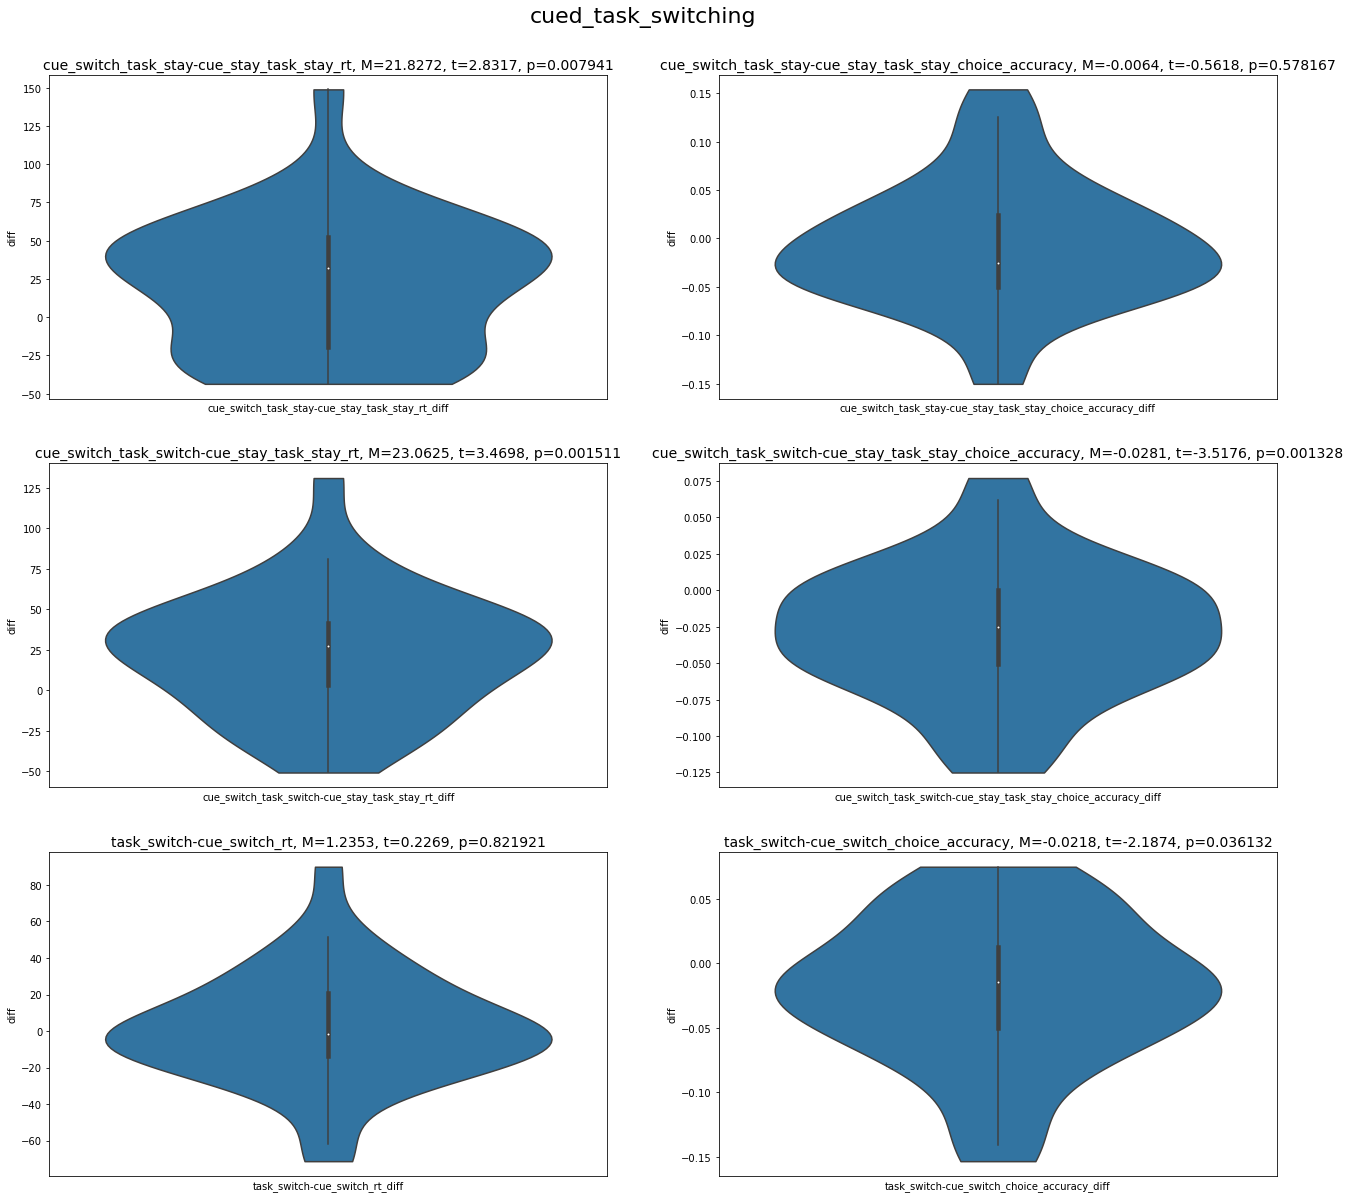

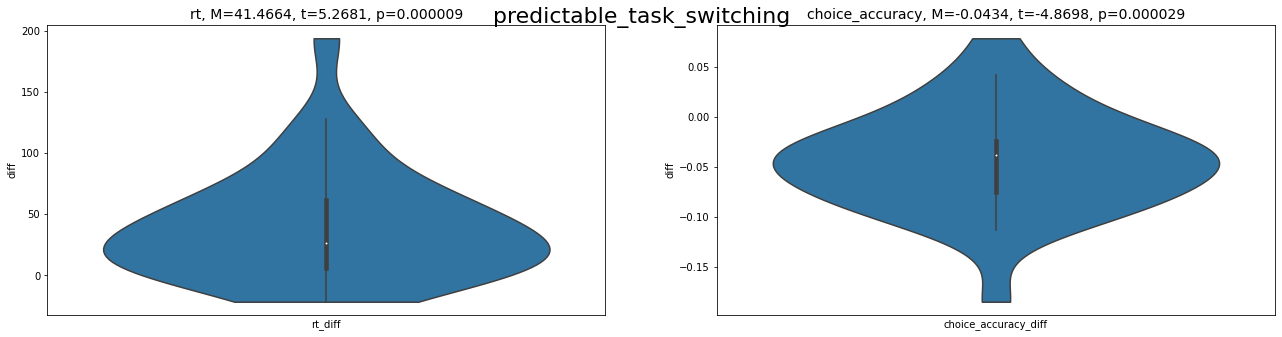

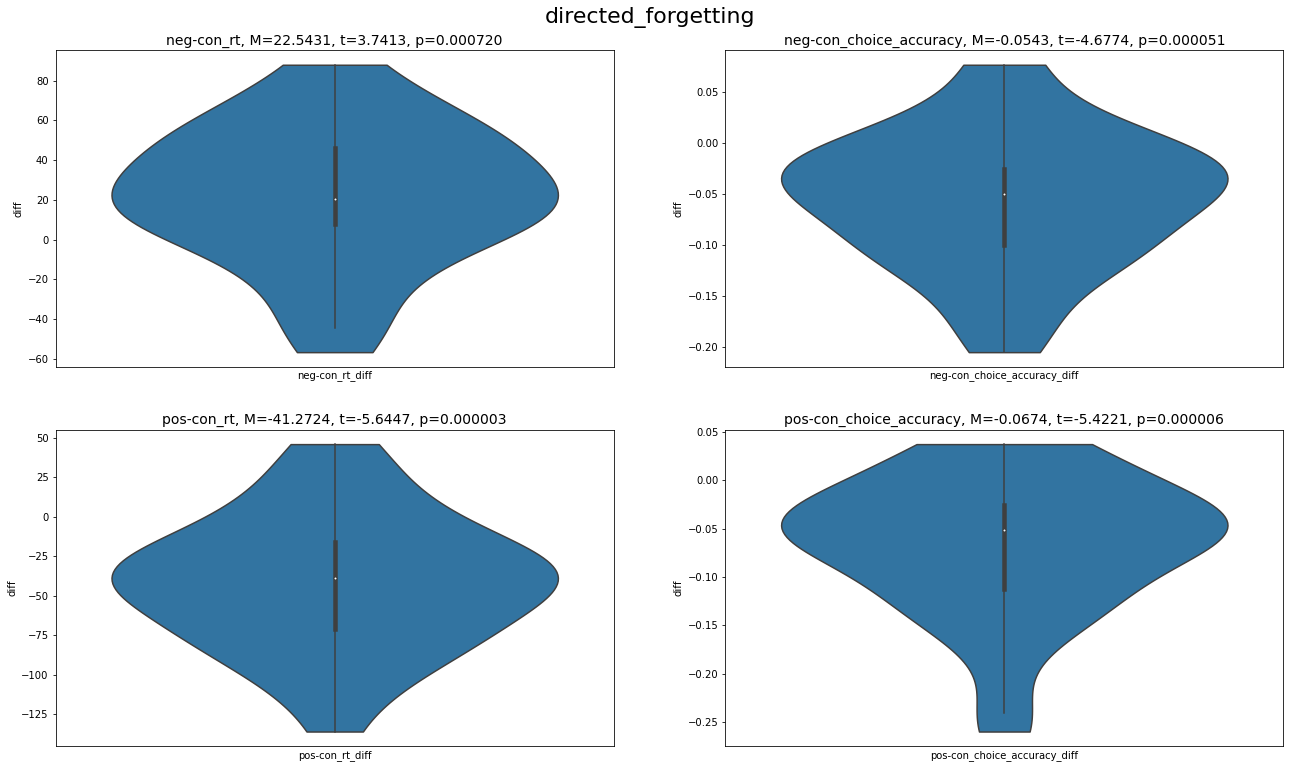

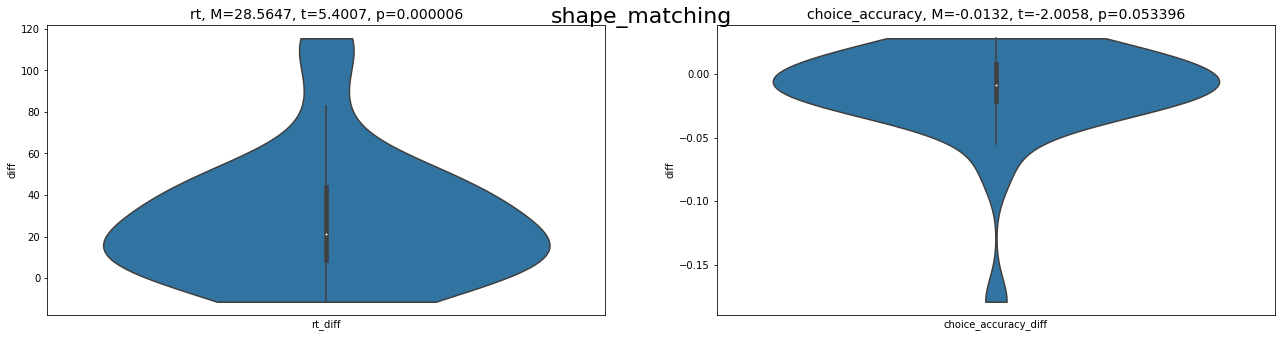

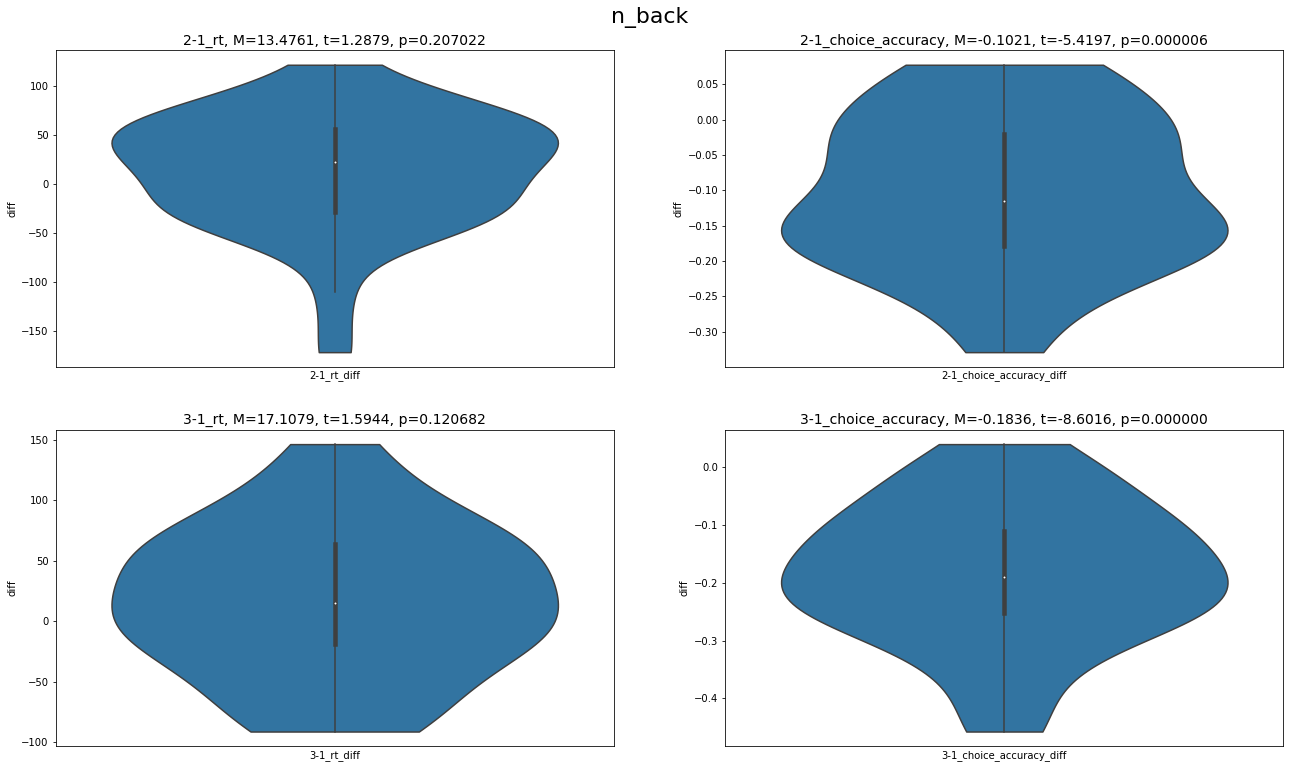

In [9]:
simple_info = []


for task in effect_map.keys():
    task_df = stop_data_dict['stop_signal_with_%s' % task].copy()
    effect_df = task_df.groupby('worker_id').apply(get_task_effects, task).apply(pd.Series)
    
    costs = cost_map[task] if task in cost_map.keys() else ['']

    fig, axes = plt.subplots(len(costs),2, figsize=(22,5*len(costs) + 2*(len(costs)-1)))
    for idx, cost in enumerate(costs):
        for jdx, metric in enumerate(['rt', 'choice_accuracy']):
            values = effect_df.filter(regex=f'{cost}{metric}')
            assert values.shape[1]==1 # only 1 column
            values = values[values.columns[0]]
            t,p = stats.ttest_1samp(values.values, 0)
            ax = axes[idx, jdx] if len(costs)>1 else axes[jdx]
            ax = sns.violinplot(data=values, ax=ax,cut=0)
            ax.set_ylabel('diff')
            ax.set_xticks([])
            ax.set_xlabel(f'{cost}{metric}_diff')
            ax.set_title(f'{cost}{metric}, M={values.mean():.4f}, t={t:.4f}, p={p:.6f}', fontsize=14)
            simple_info.append([
                task,
                cost if cost!='' else f'{effect_map[task]["hard"][0]}-{effect_map[task]["base"]}',
                metric,
                values.mean(),
                t,
                p,
                values.mean()/values.std()
            ])
    plt.suptitle(task, fontsize=22)
    fig.subplots_adjust(top=0.93)
    plt.show()
    plt.close()

# 2. Look at how many trials were excluded due to short SSDs

In [10]:
# init with stop signals
excluded_short_SSDs = data_excluded_for_task = pd.DataFrame(stop_data_dict['stop_signal_single_task_network'].groupby('worker_id').apply(lambda x: (x.SS_delay<200).sum()))
excluded_short_SSDs['stop_signal_single_task_network'] = excluded_short_SSDs[0]
del excluded_short_SSDs[0]
    
for task in effect_map.keys():
    data_excluded_for_task = pd.DataFrame(stop_data_dict['stop_signal_with_%s' % task].groupby('worker_id').apply(lambda x: (x.SS_delay<200).sum()))
    data_excluded_for_task[task] = data_excluded_for_task[0]
    del data_excluded_for_task[0]
    
    excluded_short_SSDs = pd.concat([excluded_short_SSDs, data_excluded_for_task], axis=1)

In [11]:
excluded_short_SSDs

,stop_signal_single_task_network,flanker,cued_task_switching,predictable_task_switching,directed_forgetting,shape_matching,n_back
worker_id,,,,,,,
s005,16,0,0,0,169,0,0
s010,0,0,0,0,48,0,22
s025,27,24,0,0,197,0,0
s044,0,0,0,0,72,0,0
s066,0,42,0,0,39,0,9
s069,0,0,0,0,123,0,0
s090,28,0,0,0,131,0,32
s126,0,0,0,0,120,1,2
s135,0,0,0,0,140,13,0


In [12]:
excluded_short_SSDs.describe()

,stop_signal_single_task_network,flanker,cued_task_switching,predictable_task_switching,directed_forgetting,shape_matching,n_back
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,7.000000,7.939394,0.030303,5.727273,85.000000,15.272727,11.000000
std,21.995738,19.665864,0.174078,32.543502,73.339536,51.006907,20.556325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,74.000000,0.000000,0.000000
75%,0.000000,3.000000,0.000000,0.000000,159.000000,1.000000,9.000000
max,121.000000,100.000000,1.000000,187.000000,210.000000,285.000000,78.000000


In [13]:
excluded_short_SSDs.sum()

stop_signal_single_task_network     231
flanker                             262
cued_task_switching                   1
predictable_task_switching          189
directed_forgetting                2805
shape_matching                      504
n_back                              363
dtype: int64

# looking at proportion excluded

In [14]:
# init with stop signals
excluded_short_SSDs = data_excluded_for_task = pd.DataFrame(stop_data_dict['stop_signal_single_task_network'].groupby('worker_id').apply(lambda x: (x.SS_delay<200).sum()/len(x)))
excluded_short_SSDs['stop_signal_single_task_network'] = excluded_short_SSDs[0]
del excluded_short_SSDs[0]
    
for task in effect_map.keys():
    data_excluded_for_task = pd.DataFrame(stop_data_dict['stop_signal_with_%s' % task].groupby('worker_id').apply(lambda x: (x.SS_delay<200).sum()/len(x)))
    data_excluded_for_task[task] = data_excluded_for_task[0]
    del data_excluded_for_task[0]
    
    excluded_short_SSDs = pd.concat([excluded_short_SSDs, data_excluded_for_task], axis=1)
excluded_short_SSDs

,stop_signal_single_task_network,flanker,cued_task_switching,predictable_task_switching,directed_forgetting,shape_matching,n_back
worker_id,,,,,,,
s005,0.111111,0.000000,0.000000,0.000000,0.704167,0.000000,0.000000
s010,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.079710
s025,0.187500,0.100000,0.000000,0.000000,0.820833,0.000000,0.000000
s044,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000
s066,0.000000,0.175000,0.000000,0.000000,0.162500,0.000000,0.032609
s069,0.000000,0.000000,0.000000,0.000000,0.512500,0.000000,0.000000
s090,0.194444,0.000000,0.000000,0.000000,0.545833,0.000000,0.115942
s126,0.000000,0.000000,0.000000,0.000000,0.500000,0.002381,0.007246
s135,0.000000,0.000000,0.000000,0.000000,0.583333,0.030952,0.000000


In [15]:
excluded_short_SSDs.describe()

,stop_signal_single_task_network,flanker,cued_task_switching,predictable_task_switching,directed_forgetting,shape_matching,n_back
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.048611,0.033081,0.000126,0.023864,0.354167,0.036364,0.039855
std,0.152748,0.081941,0.000725,0.135598,0.305581,0.121445,0.074479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.037500,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.308333,0.000000,0.000000
75%,0.000000,0.012500,0.000000,0.000000,0.662500,0.002381,0.032609
max,0.840278,0.416667,0.004167,0.779167,0.875000,0.678571,0.282609


In [16]:
excluded_short_SSDs.describe().loc[['mean', 'std'], :]

,stop_signal_single_task_network,flanker,cued_task_switching,predictable_task_switching,directed_forgetting,shape_matching,n_back
mean,0.048611,0.033081,0.000126,0.023864,0.354167,0.036364,0.039855
std,0.152748,0.081941,0.000725,0.135598,0.305581,0.121445,0.074479


# looking at n-back performance

In [17]:
nback_df = stop_data_dict['stop_signal_with_n_back'].copy().reset_index()
go_resp_idx = (nback_df['stop_signal_condition']=='go') &(nback_df['rt'] > 0) # subset to go responses only
nback_df = nback_df[go_resp_idx]

nback_performance_summary = nback_df.groupby(['delay_condition', 'n_back_condition', 'worker_id']).mean().loc[:, ['rt', 'choice_accuracy']].reset_index()
nback_performance_summary.head()

,delay_condition,n_back_condition,worker_id,rt,choice_accuracy
0,1.0,match,s005,817.166667,0.916667
1,1.0,match,s010,811.454545,0.181818
2,1.0,match,s025,865.400000,0.500000
3,1.0,match,s044,703.642857,1.000000
4,1.0,match,s066,545.833333,1.000000


In [18]:
# adding in SSRT estimates for each condition
nback_SSRT_df = metric_dict['SSRT'].loc[:,['n_back_DC_SSRT', 'n_back_DE_SSRT', 'n_back_OTHER_SSRT']].reset_index()

nback_performance_summary['SSRT'] = None
nback_performance_summary['id'] = None

nback_performance_summary.loc[(nback_performance_summary.delay_condition==1) & (nback_performance_summary.n_back_condition=='match'), ['SSRT', 'id']] = nback_SSRT_df[['n_back_DC_SSRT', 'ID']].values
nback_performance_summary.loc[(nback_performance_summary.delay_condition==1) & (nback_performance_summary.n_back_condition=='mismatch'), ['SSRT', 'id']] = nback_SSRT_df[['n_back_DC_SSRT', 'ID']].values

nback_performance_summary.loc[(nback_performance_summary.delay_condition==2) & (nback_performance_summary.n_back_condition=='match'), ['SSRT', 'id']] = nback_SSRT_df[['n_back_DE_SSRT', 'ID']].values
nback_performance_summary.loc[(nback_performance_summary.delay_condition==2) & (nback_performance_summary.n_back_condition=='mismatch'), ['SSRT', 'id']] = nback_SSRT_df[['n_back_DE_SSRT', 'ID']].values

nback_performance_summary.loc[(nback_performance_summary.delay_condition==3) & (nback_performance_summary.n_back_condition=='match'), ['SSRT', 'id']] = nback_SSRT_df[['n_back_OTHER_SSRT', 'ID']].values
nback_performance_summary.loc[(nback_performance_summary.delay_condition==3) & (nback_performance_summary.n_back_condition=='mismatch'), ['SSRT', 'id']] = nback_SSRT_df[['n_back_OTHER_SSRT', 'ID']].values


assert nback_performance_summary['worker_id'].equals(nback_performance_summary['id']) # make sure SSRTs were aligned with other peformance metrics

nback_performance_summary.head()

,delay_condition,n_back_condition,worker_id,rt,choice_accuracy,SSRT,id
0,1.0,match,s005,817.166667,0.916667,198.0,s005
1,1.0,match,s010,811.454545,0.181818,218.258065,s010
2,1.0,match,s025,865.400000,0.500000,292.875,s025
3,1.0,match,s044,703.642857,1.000000,229.645161,s044
4,1.0,match,s066,545.833333,1.000000,259.129032,s066


In [19]:
# remove sub who was an outlier at load==3

print(nback_performance_summary[nback_performance_summary.SSRT.isnull()])
nback_performance_summary = nback_performance_summary[nback_performance_summary.worker_id!='s320']

     delay_condition n_back_condition worker_id          rt  choice_accuracy  \
149              3.0            match      s320  756.909091         0.181818   
182              3.0         mismatch      s320  746.255814         0.674419   

    SSRT    id  
149  NaN  s320  
182  NaN  s320  


In [20]:
nback_performance_summary.groupby(['delay_condition', 'n_back_condition']).mean()

rt  choice_accuracy
delay_condition n_back_condition                             
1.0             match             708.812983         0.753041
                mismatch          716.206940         0.937945
2.0             match             715.137592         0.580357
                mismatch          737.715288         0.858208
3.0             match             742.728456         0.461648
                mismatch          739.158801         0.789529

In [21]:
nback_performance_summary.groupby(['delay_condition', 'n_back_condition']).std()

rt  choice_accuracy
delay_condition n_back_condition                             
1.0             match             146.799917         0.247543
                mismatch          133.769722         0.101021
2.0             match             113.407088         0.230555
                mismatch          118.171910         0.107590
3.0             match             124.151393         0.227525
                mismatch          127.855446         0.148991

# choice accuracy drops on match trials, especially with increasing load

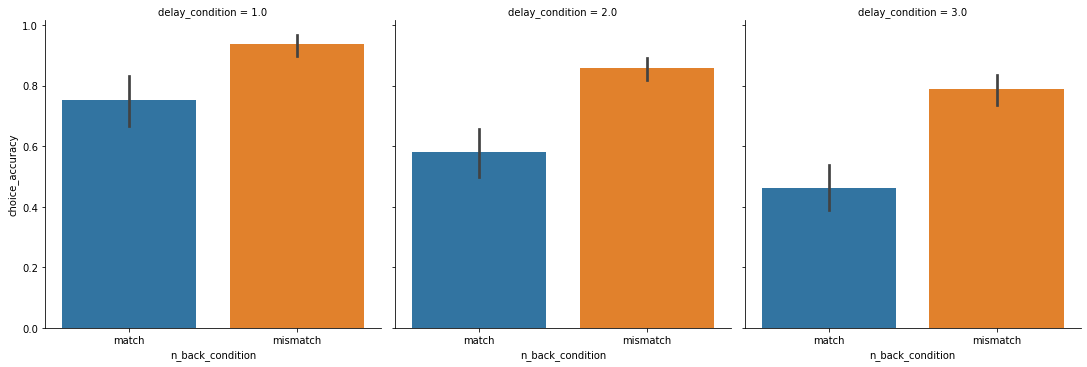

In [22]:
_ = sns.catplot(x='n_back_condition', y='choice_accuracy', col='delay_condition', data=nback_performance_summary, kind='bar')

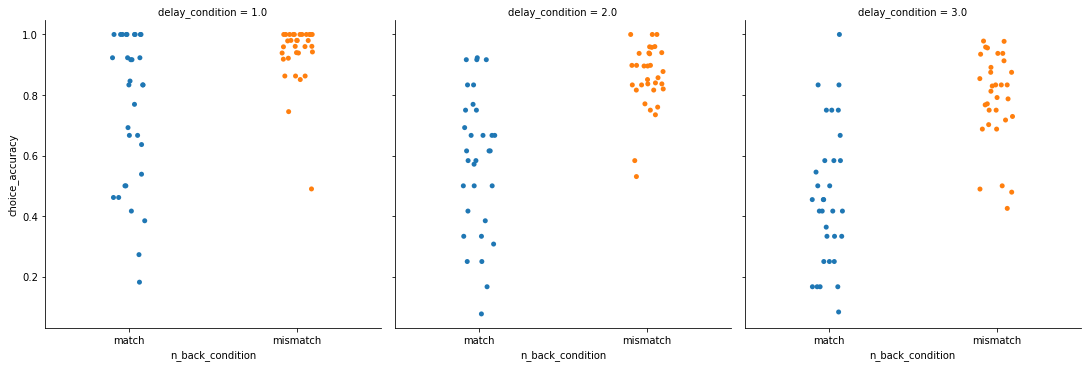

In [23]:
_ = sns.catplot(x='n_back_condition', y='choice_accuracy', col='delay_condition', data=nback_performance_summary, kind='strip')

# RT is not as affected by mis/match 

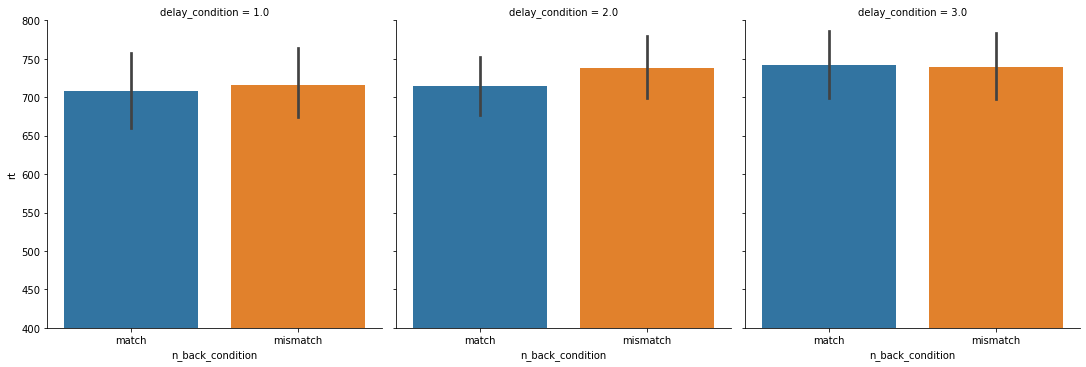

In [24]:
g = sns.catplot(x='n_back_condition', y='rt', col='delay_condition', data=nback_performance_summary, kind='bar')
_ = g.set(ylim=(400, 800))

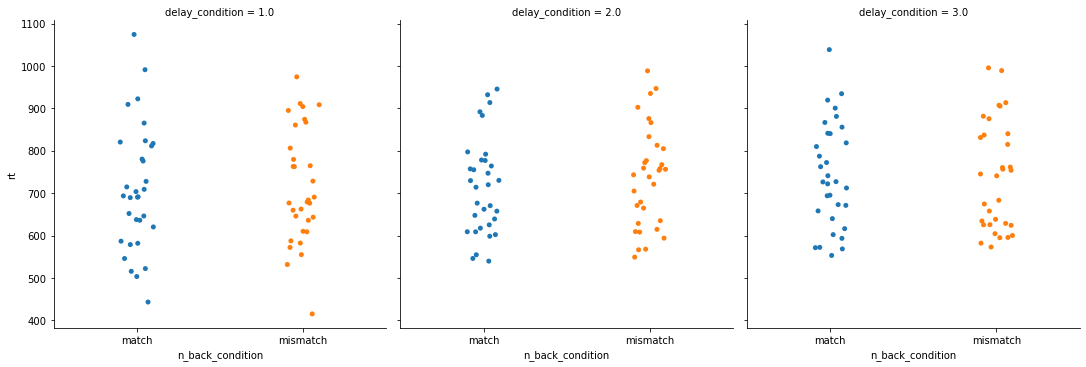

In [25]:
_ = sns.catplot(x='n_back_condition', y='rt', col='delay_condition', data=nback_performance_summary, kind='strip')

# t-test SSRTs

In [26]:
from scipy.stats import ttest_rel

In [27]:
nback_SSRT_df = metric_dict['SSRT'].loc[:,['n_back_DC_SSRT', 'n_back_DE_SSRT', 'n_back_OTHER_SSRT']].reset_index()
nback_SSRT_df = nback_SSRT_df.rename(columns={'n_back_DC_SSRT': 'Load1', 'n_back_DE_SSRT': 'Load2', 'n_back_OTHER_SSRT': 'Load3'})
nback_SSRT_df = nback_SSRT_df[nback_SSRT_df.notnull().all(1)] # drop sub with nan for load 3 (3SDs away from the mean)
nback_SSRT_df.head()

,ID,Load1,Load2,Load3
0,s005,198.000000,194.032258,264.333333
1,s010,218.258065,317.000000,390.000000
2,s025,292.875000,322.451613,306.333333
3,s044,229.645161,330.064516,179.000000
4,s066,259.129032,239.625000,223.666667


In [28]:
ttest_rel(nback_SSRT_df['Load3'], nback_SSRT_df['Load1'])

Ttest_relResult(statistic=2.419404698003577, pvalue=0.02160457101807462)

In [29]:
from scipy.stats import ttest_1samp # just showing that this is identical
ttest_1samp(nback_SSRT_df['Load3'].sub(nback_SSRT_df['Load1']), popmean=0)

Ttest_1sampResult(statistic=2.419404698003577, pvalue=0.02160457101807462)

In [30]:
ttest_rel(nback_SSRT_df['Load3'], nback_SSRT_df['Load2'])

Ttest_relResult(statistic=-0.8893913249395213, pvalue=0.38064285290697153)